n_components: 1, RMSE: 1.5980
n_components: 21, RMSE: 1.1486
n_components: 41, RMSE: 1.0935
n_components: 61, RMSE: 1.0657
n_components: 81, RMSE: 1.0559
n_components: 101, RMSE: 1.0882
n_components: 121, RMSE: 1.1217
n_components: 141, RMSE: 1.1416
n_components: 161, RMSE: 1.1591
n_components: 181, RMSE: 1.1709
n_components: 201, RMSE: 1.1889
n_components: 221, RMSE: 1.2044
n_components: 241, RMSE: 1.2171
n_components: 261, RMSE: 1.2221
n_components: 281, RMSE: 1.2238
n_components: 301, RMSE: 1.2246
n_components: 321, RMSE: 1.2262
n_components: 341, RMSE: 1.2269
n_components: 361, RMSE: 1.2271
n_components: 381, RMSE: 1.2271
n_components: 401, RMSE: 1.2271
n_components: 421, RMSE: 1.2271
n_components: 441, RMSE: 1.2271
n_components: 461, RMSE: 1.2271
n_components: 481, RMSE: 1.2271
Rough estimate of optimal number of components: 81


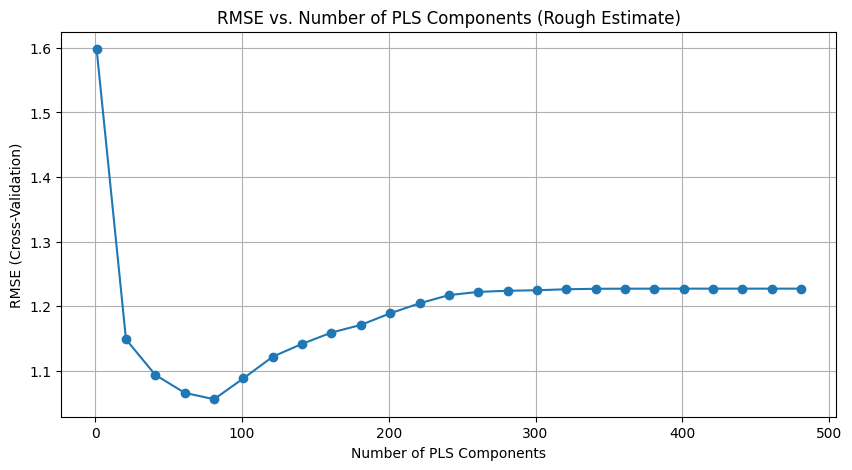

In [25]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.cross_decomposition import PLSRegression
from sklearn.metrics import mean_squared_error
from scipy.stats import pearsonr
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter

# Load your cleaned data
data = pd.read_csv('data.csv')
data = data.drop(columns=['Unnamed: 0'])

# Define target variable
target = 'oc_iso.10694_w.pct'

# Extract features and target
X1 = data.drop(columns=[target]).values
y1 = data[target].values

# Create a boolean mask where y values are <= 10
mask = y1 <= 10

# Apply mask to filter X and y
X = X1[mask]
y = y1[mask]

# Apply Savitzky-Golay smoothing filter
def apply_savitzky_golay(X, window_length=11, polyorder=2, deriv=0, delta=2):
    smoothed_X = savgol_filter(X, window_length=window_length, polyorder=polyorder, deriv=deriv, delta=delta, axis=0)
    return smoothed_X

# Apply Standard Normal Variate (SNV) transformation
def standard_normal_variate(X):
    snv_X = (X - np.mean(X, axis=1, keepdims=True)) / np.std(X, axis=1, keepdims=True)
    return snv_X

# Optionally apply Savitzky-Golay filter and SNV transformation
# X_sg = apply_savitzky_golay(X, window_length=11, polyorder=2, deriv=0, delta=2)
# X_snv = standard_normal_variate(X_sg)

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Function to calculate RMSE using cross-validation
def calculate_rmse(n_components, X_train, y_train):
    pls = PLSRegression(n_components=n_components)
    # Use negative mean squared error as cross-validation scoring
    mse = cross_val_score(pls, X_train, y_train, cv=5, scoring='neg_mean_squared_error')
    rmse = np.sqrt(-mse).mean()  # Take square root of MSE and average it across folds
    return rmse

# Test a range of n_components in larger increments
component_step = 20  # Test every 20 components for efficiency
max_components = min(X_train.shape[0], X_train.shape[1], 500)  # Ensure we don't test more components than features or samples
rmse_scores = []

for n in range(1, max_components + 1, component_step):
    rmse = calculate_rmse(n, X_train, y_train)
    rmse_scores.append((n, rmse))
    print(f'n_components: {n}, RMSE: {rmse:.4f}')

# Extract n_components and RMSE values
components_tested = [x[0] for x in rmse_scores]
rmse_values = [x[1] for x in rmse_scores]

# Find the range of n_components with the lowest RMSE
optimal_n_rough = components_tested[np.argmin(rmse_values)]
print(f'Rough estimate of optimal number of components: {optimal_n_rough}')

# Plot RMSE vs. number of components (in steps)
plt.figure(figsize=(10, 5))
plt.plot(components_tested, rmse_values, marker='o')
plt.xlabel('Number of PLS Components')
plt.ylabel('RMSE (Cross-Validation)')
plt.title('RMSE vs. Number of PLS Components (Rough Estimate)')
plt.grid(True)
plt.show()


n_components: 71, RMSE: 1.0566
n_components: 72, RMSE: 1.0538
n_components: 73, RMSE: 1.0556
n_components: 74, RMSE: 1.0545
n_components: 75, RMSE: 1.0528
n_components: 76, RMSE: 1.0548
n_components: 77, RMSE: 1.0572
n_components: 78, RMSE: 1.0549
n_components: 79, RMSE: 1.0620
n_components: 80, RMSE: 1.0563
n_components: 81, RMSE: 1.0559
n_components: 82, RMSE: 1.0564
n_components: 83, RMSE: 1.0581
n_components: 84, RMSE: 1.0602
n_components: 85, RMSE: 1.0640
n_components: 86, RMSE: 1.0650
n_components: 87, RMSE: 1.0689
n_components: 88, RMSE: 1.0689
n_components: 89, RMSE: 1.0733
n_components: 90, RMSE: 1.0709
Fine-tuned optimal number of components: 75


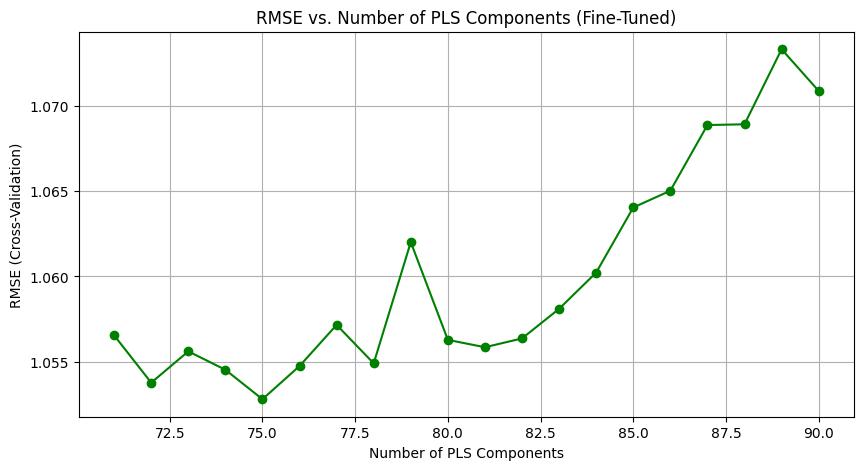

Root Mean Squared Error (RMSE) on test set: 1.0682
Correlation coefficient: 0.7901


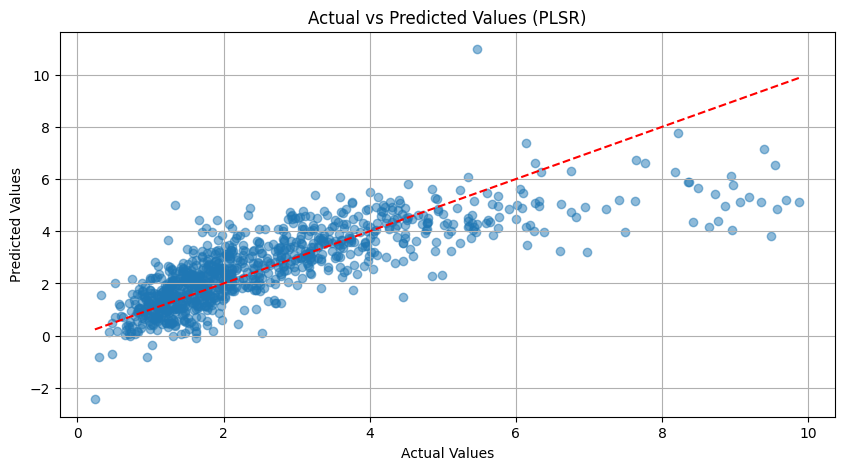

In [26]:
# Now fine-tune around the rough estimate
optimal_n_rough = 81

fine_tune_range = list(range(max(1, optimal_n_rough - 10), min(max_components, optimal_n_rough + 10)))

fine_rmse_scores = []

for n in fine_tune_range:
    rmse = calculate_rmse(n, X_train, y_train)
    fine_rmse_scores.append((n, rmse))
    print(f'n_components: {n}, RMSE: {rmse:.4f}')

# Extract refined n_components and RMSE values
fine_components_tested = [x[0] for x in fine_rmse_scores]
fine_rmse_values = [x[1] for x in fine_rmse_scores]

# Find the optimal number of components with the lowest RMSE in the fine-tuned range
optimal_n_fine = fine_components_tested[np.argmin(fine_rmse_values)]
print(f'Fine-tuned optimal number of components: {optimal_n_fine}')

# Plot RMSE vs. number of components (fine-tuned)
plt.figure(figsize=(10, 5))
plt.plot(fine_components_tested, fine_rmse_values, marker='o', color='green')
plt.xlabel('Number of PLS Components')
plt.ylabel('RMSE (Cross-Validation)')
plt.title('RMSE vs. Number of PLS Components (Fine-Tuned)')
plt.grid(True)
plt.show()

# Now use the fine-tuned optimal number of components in your final PLS model
pls = PLSRegression(n_components=optimal_n_fine)
pls.fit(X_train, y_train)

# Make predictions on the test set
y_pred = pls.predict(X_test).squeeze()

# Calculate test RMSE
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f'Root Mean Squared Error (RMSE) on test set: {rmse:.4f}')

# Calculate correlation coefficient
correlation, _ = pearsonr(y_test, y_pred)
print(f'Correlation coefficient: {correlation:.4f}')

# Plot actual vs. predicted values
plt.figure(figsize=(10, 5))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--')  # Perfect prediction line
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Actual vs Predicted Values (PLSR)')
plt.grid(True)
plt.show()


In [3]:
print(pls)

PLSRegression(n_components=45)


In [4]:
print("x_weights_ (feature weights):", pls.x_weights_)

x_weights_ (feature weights): [[ 0.03046622  0.00307887  0.04243248 ...  0.10006334 -0.02372432
  -0.04726668]
 [ 0.03039925  0.00607622  0.05102285 ...  0.07057327 -0.0346126
  -0.00465934]
 [ 0.03030425  0.00910879  0.05919236 ...  0.0249105  -0.0121986
   0.00627554]
 ...
 [ 0.03533257  0.07757088  0.02110224 ...  0.00990111  0.05966561
  -0.03559067]
 [ 0.03533264  0.07777502  0.02167215 ... -0.00011835  0.08428038
  -0.05681529]
 [ 0.03533129  0.07800961  0.02242926 ... -0.00508259  0.10571191
  -0.06685182]]


In [5]:
print("x_weights_ shape:", pls.x_weights_.shape)


x_weights_ shape: (1051, 45)


In [9]:
X_test.shape



(967, 1051)

In [13]:
type(X)


numpy.ndarray

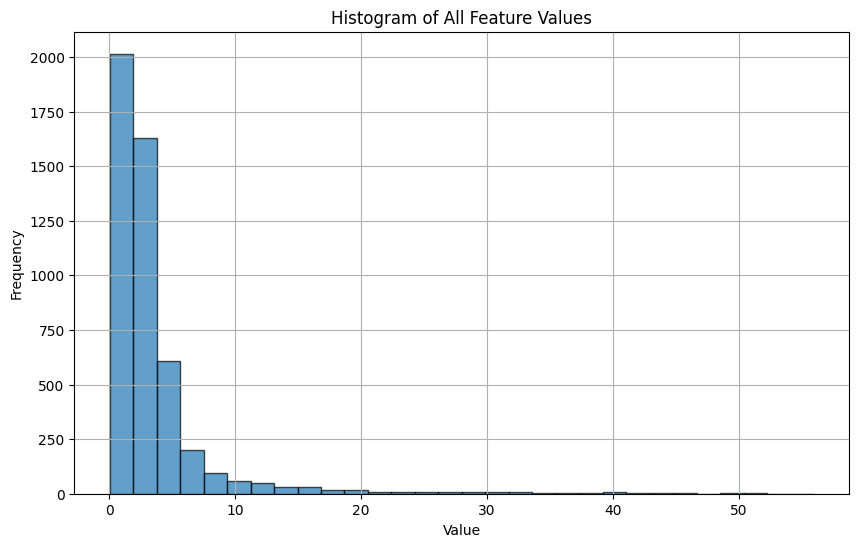

In [20]:
all_values = y.flatten()

# Plot histogram of all feature values
plt.figure(figsize=(10, 6))
plt.hist(all_values, bins=30, edgecolor='k', alpha=0.7)
plt.title('Histogram of All Feature Values')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()